In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
#cesta k súboru na Google Drive
csv_path = "/content/drive/MyDrive/data/new_merged.csv"

#načítanie CSV súboru, len prvých 100 riadkov
df = pd.read_csv(csv_path)
image_paths = df["img"].tolist()


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import pandas as pd

#načítanie CSV súboru s cestami k obrázkom
csv_path = "/content/drive/MyDrive/data/new_merged.csv"
df = pd.read_csv(csv_path)
image_paths = df["img"].tolist()

#definovanie transformačných operácií pre ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#vlastná trieda Dataset pre načítanie obrázkov zo súborov
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img_path = os.path.join("/content/drive/MyDrive/", img_path)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

#načítanie štítkov
labels = torch.tensor(torch.load("/content/drive/MyDrive/labels.pt"), dtype=torch.long)

#rozdelenie datasetu na 80% trénovacích dát a 10% validáčných dát a 10% testovacích dát)
dataset = ImageDataset(image_paths, labels, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

#vytvorenie dataloaderov
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#definícia modelu ResNet-50 na binárnu klasifikáciu
class ResNetBinaryClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetBinaryClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

#inicializácia modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetBinaryClassifier().to(device)

#definovanie loss funkcie a optimizéra
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

#trénovací cyklus
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        #výpočet presnosti
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        #každých 100 batchov vypíšeme priebeh tréningu
        if (batch_idx + 1) % 100 == 0:
            print(f" Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    #po každej epoche vypíšeme celkové výsledky
    train_accuracy = correct_train / total_train
    print(f" Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

#testovanie modelu
model.eval()
correct = 0
total = 0
class_counts = {0: 0, 1: 0}

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        #počet predikcií v jednotlivých triedach
        for p in predicted:
            class_counts[p.item()] += 1

        #každých 100 batchov vypíšeme presnosť na testovacej množine
        if total % 100 == 0:
            print(f" Testovaných {total} vzoriek, Aktuálna presnosť: {correct / total:.4f}")

#výpis výsledkov
test_accuracy = correct / total
print(f" Test Accuracy: {test_accuracy:.4f}")
print(f" Počet predikovaných NETOXICKÝCH (0): {class_counts[0]}")
print(f" Počet predikovaných TOXICKÝCH (1): {class_counts[1]}")


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/resnet_own.pth")

In [ ]:
import os
import json
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

#cesta k dátam a modelu
jsonl_path = "/content/drive/MyDrive/data/test_unseen.jsonl"
model_path = "/content/drive/MyDrive/resnet_own.pth"

#transformácie
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#načítanie dát z JSONL
records = []
with open(jsonl_path, "r") as f:
    for line in f:
        records.append(json.loads(line.strip()))
df = pd.DataFrame(records)
image_paths = df["img"].tolist()
labels = torch.tensor(df["label"].tolist(), dtype=torch.long)

#vlastná trieda dataset
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = os.path.join("/content/drive/MyDrive/", self.image_paths[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

#dataset a dataloader (celý test_seen.jsonl sa použije)
dataset = ImageDataset(image_paths, labels, transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

#definícia modelu
class ResNetBinaryClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNetBinaryClassifier, self).__init__()
        self.resnet = models.resnet50(pretrained=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

#načítanie modelu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetBinaryClassifier().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

#testovanie s tqdm
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testovanie"):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

#výpočet metrík
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

# Výpis
print("Výsledky modelu na test_seen.jsonl:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Testovanie: 100%|██████████| 63/63 [28:02<00:00, 26.71s/it]

Výsledky modelu na test_seen.jsonl:
Accuracy:  0.8155
Precision: 0.8268
Recall:    0.6427
F1 Score:  0.7232


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


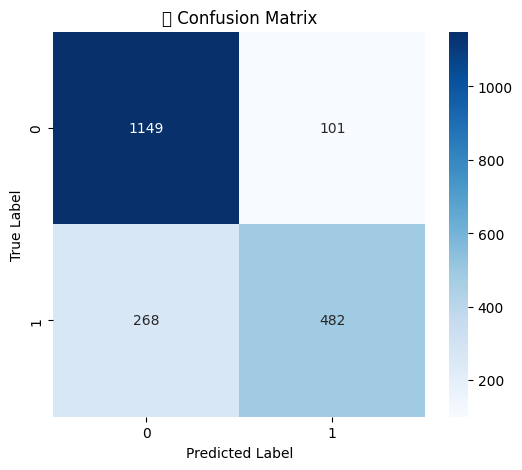

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

#vykreslenie confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
